# Resale data in Singapore - EDA

This notebook analyses the Resale data in Singapore from 1990 to 2021

The machine learning models is in the other notebooks: Resale Prices with lat lon and Resale price prediction

All data is available from data.gov.sg

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os
%matplotlib inline

In [2]:
# more consistent as
path = 'resale-flat-prices'
files = os.listdir(path)


In [3]:
csv_files = [os.path.join(path,csv) for csv in files if ".csv" in csv ]
print(csv_files)

['resale-flat-prices\\resale-flat-prices-based-on-approval-date-1990-1999.csv', 'resale-flat-prices\\resale-flat-prices-based-on-approval-date-2000-feb-2012.csv', 'resale-flat-prices\\resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv', 'resale-flat-prices\\resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv', 'resale-flat-prices\\resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv']


## Preprocessing and cleaning

In [4]:
list_of_dataframes = [pd.read_csv(x, parse_dates = True) for x in csv_files]

In [5]:
#Combine 5 csv into one with concat
df = pd.concat(list_of_dataframes,ignore_index = True)
# view headers

In [6]:
# View storey range
df['storey_range'].head()

0    10 TO 12
1    04 TO 06
2    10 TO 12
3    07 TO 09
4    04 TO 06
Name: storey_range, dtype: object

In [7]:
# split storey range into two columns with a low and high
df_storey =df['storey_range'].str.split(pat = " TO ", expand=True)
df_storey = df_storey.astype(int)
df_storey.head()

,0,1
0,10,12
1,4,6
2,10,12
3,7,9
4,4,6


In [8]:
storey_range= df_storey.mean(axis = 1)

In [9]:
# shows which floor is sold more often
# however not a very accurate representation as most flats were not high floors

print(storey_range.to_frame(0).groupby(0).size().sort_values(ascending = False))

0
5.0     222115
8.0     202856
2.0     178459
11.0    170273
14.0     57677
17.0     22109
20.0     10527
23.0      6943
26.0      3032
3.0       2700
29.0      1369
13.0      1259
32.0       492
35.0       456
38.0       428
18.0       265
41.0       209
44.0        46
47.0        40
28.0        39
50.0        14
33.0         2
dtype: int64


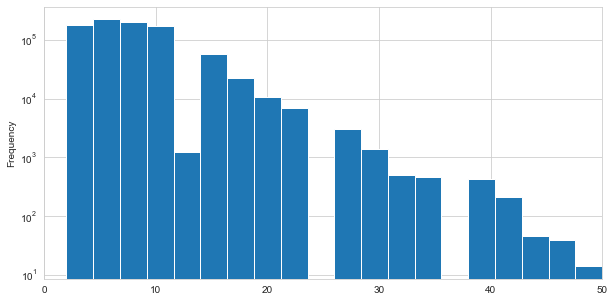

In [10]:
# hist plot, log scale due to the difference in values
storey_range.plot(kind= 'hist',log = True,xlim = (0,50),bins = 20,figsize = (10,5))
plt.show()

In [11]:
# Create target variable Dataframe
# Drop block, storey range and street name as irrelevant and difficult to work with
# Check .info() of features

price= df['resale_price']
features = df.drop(columns = ['block','storey_range','street_name'], axis = 1)
features = pd.concat([features,storey_range],axis=1)
features = features.rename(columns={0: "Storey"})
features.head()

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,Storey
0,1990-01,ANG MO KIO,1 ROOM,31.0,IMPROVED,1977,9000.0,NaN,11.0
1,1990-01,ANG MO KIO,1 ROOM,31.0,IMPROVED,1977,6000.0,NaN,5.0
2,1990-01,ANG MO KIO,1 ROOM,31.0,IMPROVED,1977,8000.0,NaN,11.0
3,1990-01,ANG MO KIO,1 ROOM,31.0,IMPROVED,1977,6000.0,NaN,8.0
4,1990-01,ANG MO KIO,3 ROOM,73.0,NEW GENERATION,1976,47200.0,NaN,5.0


In [12]:
features['flat_type'].unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI GENERATION', 'MULTI-GENERATION'], dtype=object)

In [13]:
features['flat_type'] = features['flat_type'].map({'MULTI GENERATION': 'MULTI-GENERATION'}).fillna(features['flat_type'])
features['flat_type'].unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI-GENERATION'], dtype=object)

In [14]:
# Convert objects to best possible dtypes
features.isna().sum()

month                       0
town                        0
flat_type                   0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
Storey                      0
dtype: int64

### Dealing with NaN values

Remaining_lease has many NaN values. Instead of dropping it or imputing, it can be estimated with the difference in month and lease commencement date. This is also based on the assumption that the lease is 99 years long. 

In [15]:
# Convert month and lease_commence_date to datetime 
features['lease_commence_dt']=pd.to_datetime(features['lease_commence_date'],format="%Y")
features['month'] = pd.to_datetime(features['month'],format="%Y-%m")
features.sample(5)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,Storey,lease_commence_dt
597200,2010-01-01,BUKIT PANJANG,5 ROOM,110.0,Premium Apartment,2004,440000.0,NaN,23.0,2004-01-01
344770,2001-08-01,CHOA CHU KANG,5 ROOM,133.0,Model A,1996,356000.0,NaN,8.0,1996-01-01
764948,2020-06-01,BUKIT MERAH,3 ROOM,88.0,Standard,1973,625000.0,51 years 09 months,2.0,1973-01-01
704746,2017-07-01,PUNGGOL,4 ROOM,93.0,Premium Apartment,2012,495000.0,94 years,17.0,2012-01-01
144958,1996-12-01,GEYLANG,5 ROOM,117.0,STANDARD,1977,500000.0,NaN,8.0,1977-01-01


In [16]:
# Create new col remaining_lease_dt which is the difference between month and lease_commence_date
features['current_lease_dt']=features['month']-features['lease_commence_dt']
features['current_lease_year'] = features['current_lease_dt'] / np.timedelta64(1, 'Y')
features['remaining_lease_year'] = 99-features['current_lease_year']

In [17]:
#Check if the values are similar
# tail as most of the head values are NaN
features[~features['remaining_lease'].isna()].head()

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,Storey,lease_commence_dt,current_lease_dt,current_lease_year,remaining_lease_year
656847,2015-01-01,ANG MO KIO,3 ROOM,60.0,Improved,1986,255000.0,70,8.0,1986-01-01,10592 days,28.999911,70.000089
656848,2015-01-01,ANG MO KIO,3 ROOM,68.0,New Generation,1981,275000.0,65,2.0,1981-01-01,12418 days,33.999329,65.000671
656849,2015-01-01,ANG MO KIO,3 ROOM,69.0,New Generation,1980,285000.0,64,2.0,1980-01-01,12784 days,35.001403,63.998597
656850,2015-01-01,ANG MO KIO,3 ROOM,68.0,New Generation,1979,290000.0,63,2.0,1979-01-01,13149 days,36.000739,62.999261
656851,2015-01-01,ANG MO KIO,3 ROOM,68.0,New Generation,1980,290000.0,64,8.0,1980-01-01,12784 days,35.001403,63.998597


In [18]:
features.drop(columns = ['remaining_lease','lease_commence_date','current_lease_dt']
                         ,axis=1
                        ,inplace = True)
features.head()

,month,town,flat_type,floor_area_sqm,flat_model,resale_price,Storey,lease_commence_dt,current_lease_year,remaining_lease_year
0,1990-01-01,ANG MO KIO,1 ROOM,31.0,IMPROVED,9000.0,11.0,1977-01-01,12.999582,86.000418
1,1990-01-01,ANG MO KIO,1 ROOM,31.0,IMPROVED,6000.0,5.0,1977-01-01,12.999582,86.000418
2,1990-01-01,ANG MO KIO,1 ROOM,31.0,IMPROVED,8000.0,11.0,1977-01-01,12.999582,86.000418
3,1990-01-01,ANG MO KIO,1 ROOM,31.0,IMPROVED,6000.0,8.0,1977-01-01,12.999582,86.000418
4,1990-01-01,ANG MO KIO,3 ROOM,73.0,NEW GENERATION,47200.0,5.0,1976-01-01,14.001656,84.998344


## Data analysis

## Annual trend in number of resales

In [19]:
count = features.resample('A', on='month').agg({'town':'count'})
count = count.rename(columns={"town":"No of Resales"})
count

,No of Resales
month,
1990-12-31,12505
1991-12-31,12855
1992-12-31,14503
1993-12-31,18116
1994-12-31,26373
1995-12-31,27289
1996-12-31,34919
1997-12-31,31759
1998-12-31,51095


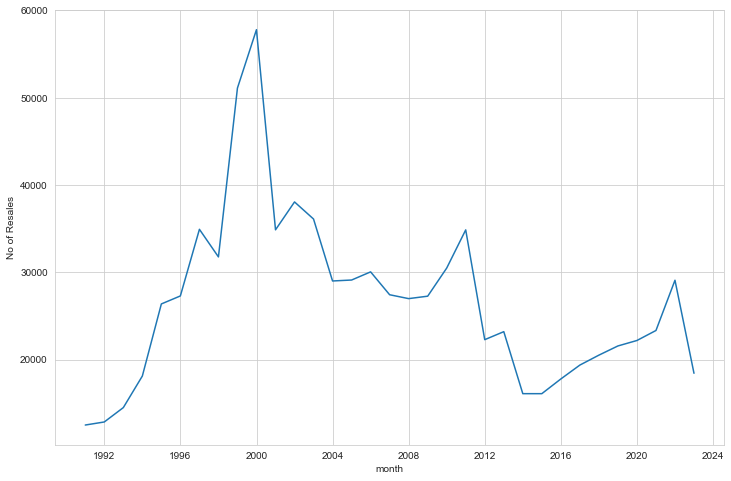

In [20]:
plt.figure(figsize = (12,8))
sns.lineplot(data=count,x='month',y='No of Resales')
plt.show()

## Average cost of housing from 1990

In [21]:
avg = features.resample('A', on='month').agg({'resale_price':np.mean})
avg = avg.rename(columns={"town":"Avg Resale Prices"})
avg.head()

,resale_price
month,
1990-12-31,68086.142263
1991-12-31,73588.938934
1992-12-31,84372.635731
1993-12-31,132807.719750
1994-12-31,172619.529936


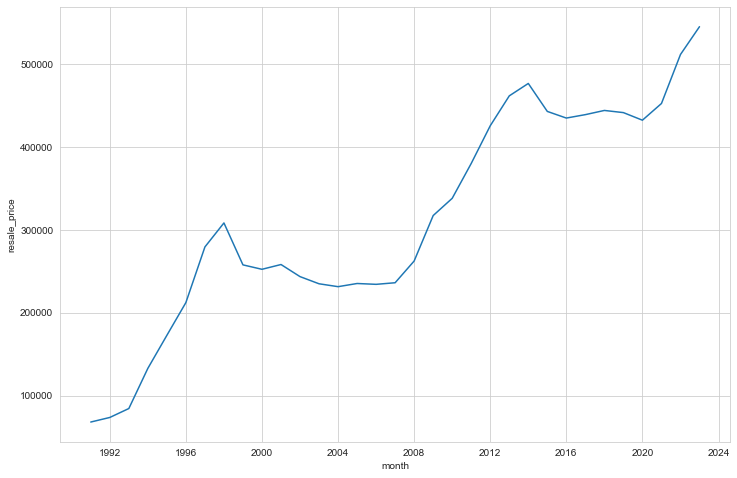

In [22]:
plt.figure(figsize = (12,8))
sns.lineplot(data=avg,x='month',y='resale_price')
plt.show()

## Top 5 locations with resale flats since 1990

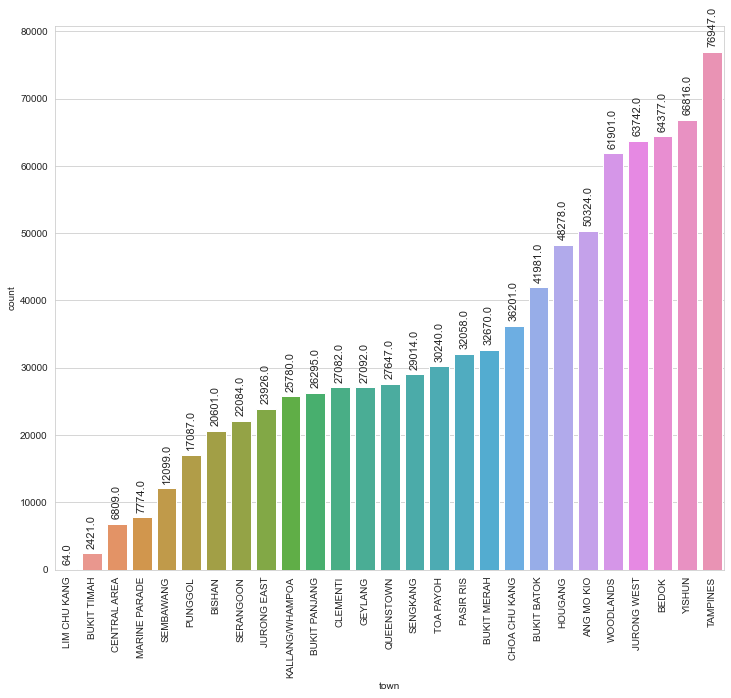

In [23]:
plt.figure(figsize = (12,10))
graph = sns.countplot(data=features,
                      x='town',
                      order=features['town'].value_counts(ascending=True).index)
plt.xticks(rotation=90)
for p in graph.patches:
    graph.annotate(format(p.get_height()), (p.get_x()+0.2, p.get_height()+1000),
                  rotation=90,
                  fontsize=11)

## Histogram plot of remaining lease

From the plot we can see most of the houses sold were right after the Minumum occupancy period of 5 years.

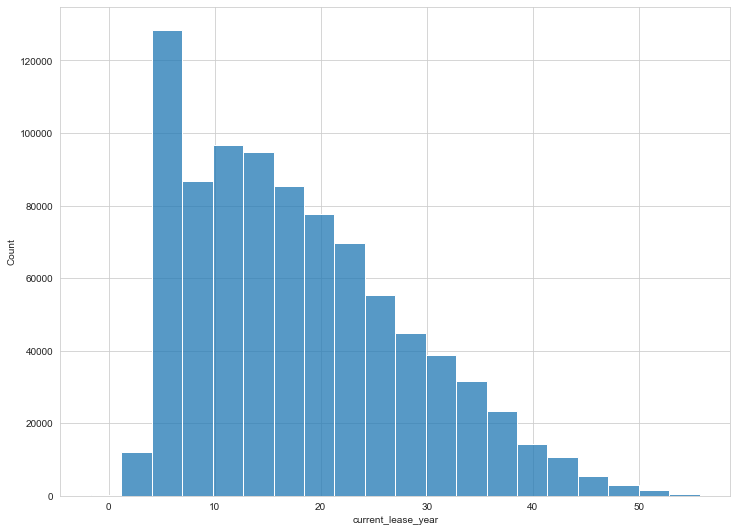

In [24]:
plt.figure(figsize = (12,9))
graph = sns.histplot(data=features,
                    x='current_lease_year',
                    bins=20)

### Flat types

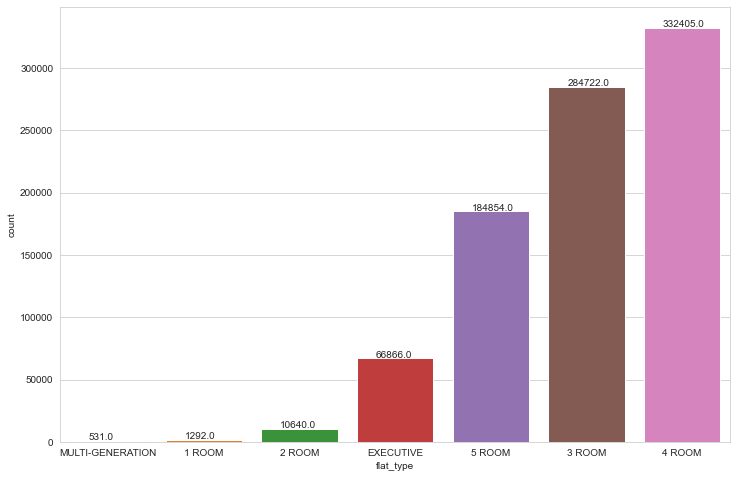

In [25]:
plt.figure(figsize = (12,8))
graph = sns.countplot(data=features,
                      x='flat_type',
                      order=features['flat_type'].value_counts(ascending=True).index)
for p in graph.patches:
    graph.annotate(format(p.get_height()), (p.get_x()+0.2, p.get_height()+1000))

## Trend of resales right after MOP. 

I use the value 93 to filter out remaining leases below 93. The assumption of 2 years is for searching of buyers and the time required to process the transaction. 

In [26]:
mop_resale = features[features['remaining_lease_year']>93]
len(mop_resale) # Show number of total resales with lease above 93

106159

In [27]:
mop_resale = mop_resale.resample('A', on='month').agg({'town':'count'})

In [28]:
mop_resale.sort_values(by='town',ascending=False).head(5) # Resample to annual and sum it up

,town
month,
2001-12-31,9861
1999-12-31,8816
2002-12-31,8677
2000-12-31,6847
1998-12-31,6281


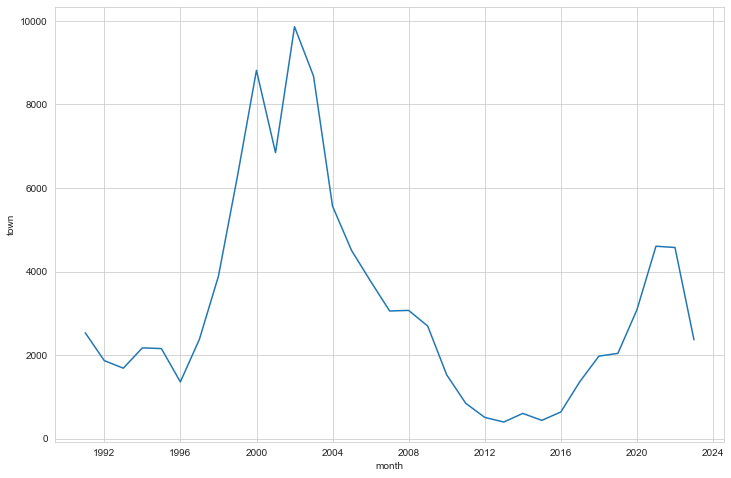

In [29]:
plt.figure(figsize = (12,8))
sns.lineplot(data=mop_resale,x='month',y='town')
plt.show()

From the above graph and data, the top 5 sales in MOP occured in 1998-2002 inclusive. After decreasing from 2001 till 2015, it begun to rise again. More data is needed to see if the trend is continuing. 

## Flat by age

### hist plot of all flat age

In [30]:
features['age'] = (datetime.now()-features['lease_commence_dt']) / np.timedelta64(1, 'Y')

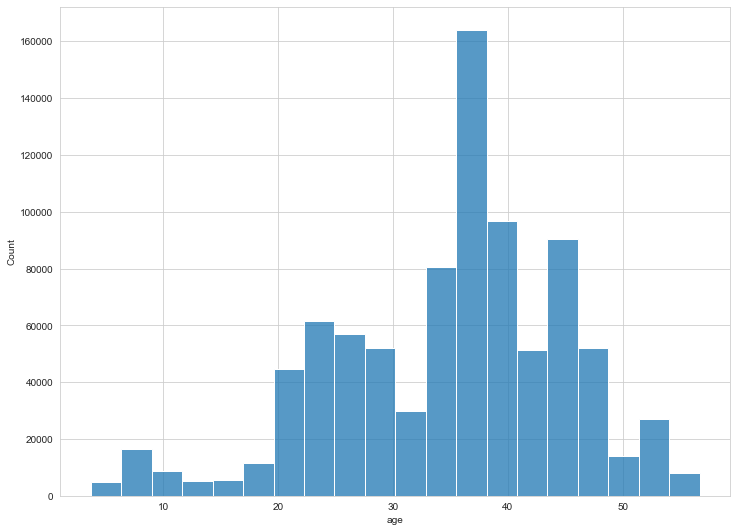

In [31]:
plt.figure(figsize = (12,9))
graph = sns.histplot(data=features,
                    x='age',
                    bins=20)

### Age by town

In [32]:
avg_town_age= features.groupby('town')['age'].median()
avg_town_age = avg_town_age.to_frame()
avg_town_age.sort_values(by='age',ascending=False).head(5)

,age
town,
QUEENSTOWN,48.697214
TOA PAYOH,47.697878
MARINE PARADE,47.697878
BUKIT MERAH,44.697132
CLEMENTI,43.697795


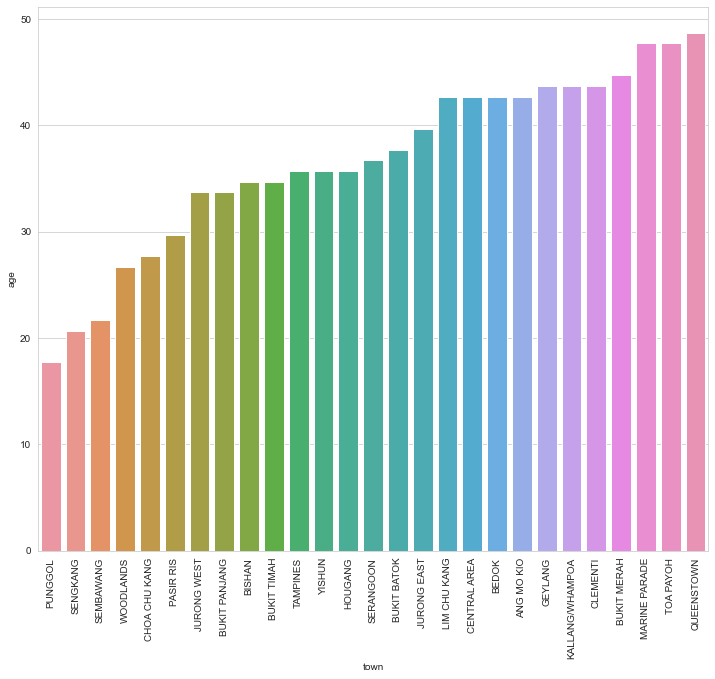

In [33]:
plt.figure(figsize = (12,10))
sns.barplot(data=avg_town_age,
            x=avg_town_age.index,
            y ='age',
            order=avg_town_age.sort_values(by='age',ascending=True).index)
plt.xticks(rotation=90)
plt.show()

## Build new Dataframe to analyse data by town from 2010 onwards

Reason is due to the rising prices from 1990 that will skew the data. 

In [41]:
features2 = features[features.month>='2010-01-01']

In [42]:
avg_town= features2.groupby('town')['resale_price'].mean()
avg_town = avg_town.to_frame()
avg_town = avg_town.rename(columns={"resale_price": "Avg Resale"})
avg_town = avg_town.round(0)
avg_town.sort_values(by = 'Avg Resale', ascending=False).head(5)

,Avg Resale
town,
BUKIT TIMAH,669880.0
BISHAN,602889.0
CENTRAL AREA,586685.0
BUKIT MERAH,549200.0
QUEENSTOWN,534909.0


In [43]:
med_town= features2.groupby('town')['resale_price'].median()
med_town = med_town.to_frame()
med_town = med_town.rename(columns={"resale_price": "Med Resale"})
med_town = med_town.round(0)
med_town.sort_values(by = 'Med Resale', ascending=False).head(5)

,Med Resale
town,
BUKIT TIMAH,665000.0
BISHAN,580000.0
BUKIT MERAH,552444.0
PASIR RIS,482000.0
CENTRAL AREA,480000.0


In [44]:
count_town= features2.groupby('town')['resale_price'].count()
count_town = count_town.to_frame()
count_town = count_town.rename(columns={"resale_price": "Count Resale"})
count_town = count_town.round(0)
count_town.sort_values(by = 'Count Resale', ascending=False).head(5)

,Count Resale
town,
WOODLANDS,21791
JURONG WEST,21346
SENGKANG,20678
TAMPINES,19712
YISHUN,18702


### Highest price based on flat type and flat model, followed by average thereafter

In [45]:
max_features =features2.groupby(['flat_type','flat_model'])['resale_price'].max()
df_max= max_features.to_frame()
df_max = df_max.round(0)
df_max.sort_values(by = 'resale_price', ascending=False).head(10)

resale_price
flat_type flat_model                          
5 ROOM    Premium Apartment Loft     1418000.0
          Improved                   1400000.0
          Type S2                    1388889.0
          DBSS                       1360000.0
EXECUTIVE Maisonette                 1288000.0
3 ROOM    Terrace                    1268000.0
EXECUTIVE Apartment                  1235000.0
5 ROOM    Premium Apartment          1230000.0
4 ROOM    Type S1                    1228000.0
          Premium Apartment Loft     1160000.0

In [46]:
# Shows the mean price based on flat type and flat model
mean_features =features2.groupby(['flat_type','flat_model'])['resale_price'].mean()
df_mean= mean_features.to_frame()
df_mean = df_mean.round(0)
df_mean.sort_values(by = 'resale_price', ascending=False).head(10)

resale_price
flat_type        flat_model                          
5 ROOM           Type S2                    1056518.0
                 Premium Apartment Loft      942170.0
4 ROOM           Type S1                     930011.0
                 Premium Apartment Loft      914606.0
5 ROOM           DBSS                        854575.0
4 ROOM           Terrace                     853615.0
3 ROOM           Terrace                     797390.0
MULTI-GENERATION Multi Generation            768037.0
EXECUTIVE        Premium Maisonette          756292.0
                 Adjoined flat               749632.0